In [ ]:
# Deep Q Networks - Getting a Deep Q network to play Ms Pacman

# Used code from: https://github.com/pythonlessons/Reinforcement_Learning/blob/master/07_Pong-reinforcement-learning_DQN_CNN/Pong-v0_DQN_CNN_TF2.py
# Used code from: https://github.com/ShivankYadav/LunarLander-using-DQN/blob/master/model.py


import os
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import cv2
import pickle
import imageio

def OurModel(input_shape, action_space, lr):
    X_input = Input(shape=(input_shape,))

    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X_input)
    X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X_input)
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    return model

class DQNAgent:
    def __init__(self, env_name):
        
        # Environment
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = 8
        self.EPISODES = 1000
        
        # Memory
        memory_size = 100000 # 2500
        self.memory = deque(maxlen=memory_size)
        
        # Exploration
        self.epsilon = 0.01 #1.0
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.995    
        
        # Hyperparameters
        self.gamma = 0.99        
        self.batch_size = 64
        self.lr = 5e-4 # 1e-4
        self.tau = 1e-3 
        
        # create main model and target model
        self.model = OurModel(input_shape=self.state_size, action_space = self.action_size, lr= self.lr)
        self.target_model = OurModel(input_shape=self.state_size, action_space = self.action_size, lr= self.lr)
        
    def update_target_model(self):        
        for t, e in zip(self.target_model.trainable_variables, self.model.trainable_variables):
            t.assign(t * (1 - self.tau) + e * self.tau)
        return
    
    # act based on agent
    def act(self, state):                
        if self.epsilon > np.random.rand():
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model(state))
        
    def replay(self):        
        if len(self.memory) > self.batch_size:
            minibatch = random.sample(self.memory, self.batch_size)
        else:
            return

        state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        action = np.zeros(self.batch_size, dtype=np.int32)
        reward = np.zeros(self.batch_size, dtype=np.float32)
        next_state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        done = np.zeros(self.batch_size, dtype=np.uint8)

        for i in range(len(minibatch)):
            state[i], action[i], reward[i], next_state[i], done[i] = minibatch[i]
                
        target = np.array(self.model(state))  
        #target_next = self.model(next_state)
        target_val = self.target_model(next_state)

        for i in range(len(minibatch)):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * np.amax(target_val[i])         
                
                # DDQN
                # a = np.argmax(target_next[i])
                # target[i][action[i]] = reward[i] + self.gamma * target_val[i][a]                 

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        
        # Soft update of the model
        self.update_target_model()

    def load(self, name):
        self.model.load_weights(name)    
        self.target_model.load_weights(name)    

    def save(self, name):
        self.model.save_weights(name)    

    def Normalise(self, frame):        
        self.env.render()          
                
        """# convert to float32
        frame = np.array(frame, dtype=np.float32)        
        mean = np.mean(frame, dtype=np.float32)
        std = np.std(frame, dtype=np.float32)
        
        frame -= mean
        frame /= std """
        
        return np.expand_dims(frame, axis=0)
    
    # reset the environment
    def reset(self):
        frame = self.env.reset()
        state = self.Normalise(frame)
        return state
    
    # perform the next step
    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.Normalise(next_state)
        return next_state, reward, done, info
    
    def run(self):
        decay_step = 0
        saved_scores = []  
        checked = False
        eps = 1.0
        eps_decay = 0.995
        
        # stores frames to make a .gif
        #frames = []
        
        
        for e in range(1, self.EPISODES + 1):
            state = self.reset()
            done = False
            score = 0
        
            while not done:
                decay_step += 1
                action = self.act(state)
                next_state, reward, done, _ = self.step(action)
                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                score += reward
                
                #frames.append(self.env.render(mode = 'rgb_array'))   
                
                # announce when buffer full
                if len(self.memory) > 99990 and not checked:
                    print('Buffer full!')
                    checked = True                    

                if done:                    
                    print('Episode: {} Score: {} Epsilon: {}'.format(e, score, self.epsilon))                     
                    saved_scores.append(score)    
                    
                    # for saving gif files
                    #imageio.mimsave('./Images/LunarLander_DQN.gif', frames, fps=30)
                    
                    if e % 100 == 0:

                        # save results
                        with open("./Results/rewards-ep-" + str(e) + ".txt", "wb") as file:
                            pickle.dump(saved_scores, file) 

                        # save model
                        self.save('./Models/DQN_Model.h5')

                        # save the replay
                        with open("./Replays/replay1.txt", "wb") as file:
                            pickle.dump(self.memory, file)                    
                    
                if decay_step % 4 == 0:
                    self.replay()
                
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon) 

        # close environemnt when finish training
        self.env.close()
        
#with open("./Replays/replay1.txt", "rb") as file:
 #   memory = pickle.load(file)

if __name__ == "__main__":
    # env_name = 'MsPacman-ram-v0'    
    env_name = 'LunarLander-v2'  
    agent = DQNAgent(env_name)
    # agent.memory = memory
    agent.load('./Models/LunarLander/DQN_Model-800ep.h5')
    agent.run()

Episode: 1 Score: 263.5132931203092 Epsilon: 0.01
Episode: 2 Score: 256.04853538457417 Epsilon: 0.01
Episode: 3 Score: 251.75595331106305 Epsilon: 0.01
Episode: 4 Score: 229.40494856934185 Epsilon: 0.01
Episode: 5 Score: 212.6766734874344 Epsilon: 0.01
Episode: 6 Score: 271.785411873051 Epsilon: 0.01
Episode: 7 Score: 245.14787092843895 Epsilon: 0.01
Episode: 8 Score: 260.37872228188303 Epsilon: 0.01


/home/hemerson/anaconda3/envs/cs285/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hemerson/anaconda3/envs/cs285/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


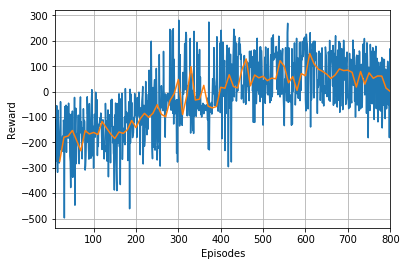

In [23]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


with open("./Results/LunarLander/rewards-ep-1000-DDQN.txt", "rb") as file:
    a = pickle.load(file)  

with open("./Results/LunarLander/rewards-ep-800.txt", "rb") as file:
    b = pickle.load(file)  
    
"""  
with open("./Results/rewards-ep-200-lr0.025.txt", "rb") as file:
    c = pickle.load(file)  
    
with open("./Results/rewards-ep-200-lr2.5e-05.txt", "rb") as file:
    d = pickle.load(file)  
    
with open("./Results/rewards-ep-200-lr2.5e-06.txt", "rb") as file:
    e = pickle.load(file)  
    
with open("./Results/rewards-ep-200-lr2.5e-07.txt", "rb") as file:
    f = pickle.load(file)  
   """ 
meana = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meana.append(np.mean(a[i - 10: i]))   
    
meanb = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meanb.append(np.mean(b[i - 10: i]))   

"""
meanc = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meanc.append(np.mean(c[i - 10: i]))   
        
meand = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meand.append(np.mean(d[i - 10: i]))   

meane = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meane.append(np.mean(e[i - 10: i]))   

meanf = []       
for i in range(len(a)):    
    if i % 10 == 0:
        meanf.append(np.mean(f[i - 10: i])) """  

x1 = np.array(range(1,101)) * 10
y1 = meana

x2 = np.array(range(1,101)) * 10
y2 = meanb

x3 = range(1, 1001)
y3 = a

x4 = range(1, 801)
y4 = b

plt.plot(x3,y3)
#plt.plot(x4,y4)

plt.plot(x1,y1)
#plt.plot(x2,y2)
"""plt.plot(x1,y5)
plt.plot(x1,y6)"""
plt.xlim(10, 800)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid(alpha=1.0)
# plt.legend(('0.00025','0.005', '0.025', '2.5e-05', '2.5e-06', '2.5e-07'))

#plt.savefig('./Images/DDQN_1000ep.png')

# plt.show()
    
    
